In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
import PIL
import PIL.Image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
import pandas as pd
import tensorflow as tf
%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_directory = '/content/drive/MyDrive/Unet/Tissue Images'
mask_directory = '/content/drive/MyDrive/Unet/png_images/'

In [5]:
SIZE = 1000
num_images = 37

In [8]:
image_names = glob.glob("/content/drive/MyDrive/Unet/Tissue Images/*.tif")
print(image_names)

['/content/drive/MyDrive/Unet/Tissue Images/TCGA-G9-6356-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-G9-6363-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-A7-A13E-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-49-4488-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-HE-7129-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-A7-A13F-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-38-6178-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-AR-A1AS-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-G9-6348-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-50-5931-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-HE-7130-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-B0-5711-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-AR-A1AK-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-HE

In [9]:
image_names.sort()
print(image_names)


['/content/drive/MyDrive/Unet/Tissue Images/TCGA-18-5592-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-21-5784-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-21-5786-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-38-6178-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-49-4488-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-50-5931-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-A7-A13E-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-A7-A13F-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-AR-A1AK-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-AR-A1AS-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-AY-A8YK-01A-01-TS1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-B0-5698-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-B0-5710-01Z-00-DX1.tif', '/content/drive/MyDrive/Unet/Tissue Images/TCGA-B0

In [10]:
image_names_subset = image_names[0:num_images]

In [12]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [13]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [14]:
mask_names = glob.glob("/content/drive/MyDrive/Unet/png_images/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [15]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))


Image data shape is:  (37, 1000, 1000, 1)
Mask data shape is:  (37, 1000, 1000, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [16]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

**Sanity check for images**

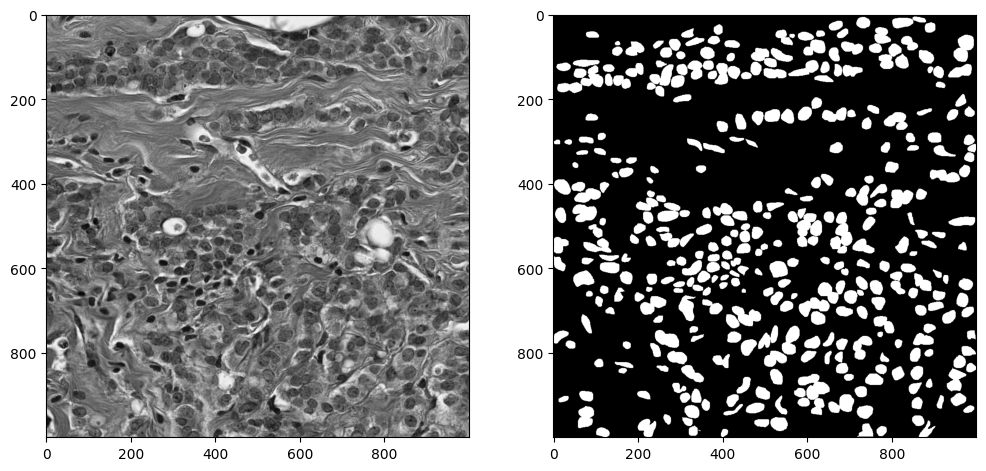

In [18]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [19]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512) #Bridge

    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d3)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [20]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [21]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 1000,   640         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1000, 1000,   256        ['conv2d[0][0]']                 
 alization)                     64)                                                   

In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
from tensorflow.keras.callbacks import TensorBoard
log_dir = "/content/drive/MyDrive/Unet/tensor_logs_2/"
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [24]:
history = model.fit(X_train, y_train, 
                    batch_size = 2, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/25
15/15 [==============================] - 73s 3s/step - loss: 0.4519 - accuracy: 0.8003 - val_loss: 0.6498 - val_accuracy: 0.6443
Epoch 2/25
15/15 [==============================] - 25s 2s/step - loss: 0.3926 - accuracy: 0.8264 - val_loss: 66.1637 - val_accuracy: 0.7448
Epoch 3/25
15/15 [==============================] - 25s 2s/step - loss: 0.3828 - accuracy: 0.8281 - val_loss: 7.3516 - val_accuracy: 0.7448
Epoch 4/25
15/15 [==============================] - 25s 2s/step - loss: 0.3702 - accuracy: 0.8351 - val_loss: 16.4163 - val_accuracy: 0.2553
Epoch 5/25
15/15 [==============================] - 26s 2s/step - loss: 0.3652 - accuracy: 0.8374 - val_loss: 2.3112 - val_accuracy: 0.2669
Epoch 6/25
15/15 [==============================] - 25s 2s/step - loss: 0.3590 - accuracy: 0.8417 - val_loss: 1.0584 - val_accuracy: 0.5373
Epoch 7/25
15/15 [==============================] - 25s 2s/step - loss: 0.3484 - accuracy: 0.8438 - val_loss: 0.6114 - val_accuracy: 0.7558
Epoch 8/25
15/15 [

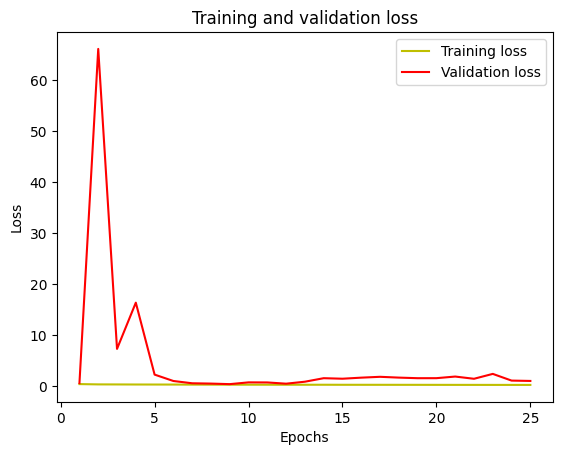

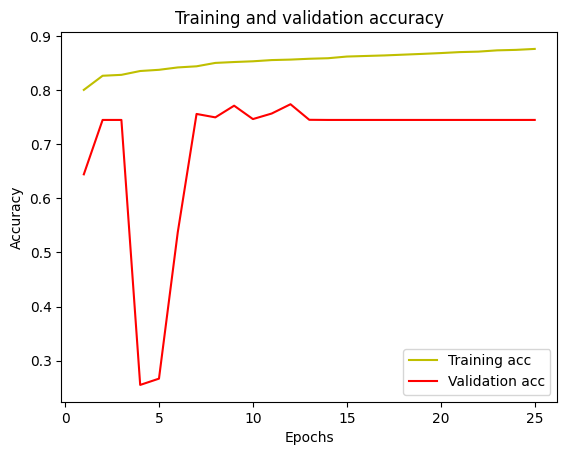

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



#after 15th epoch while our training accuracy keep increasing our loss and validation is about constant.. which means over fitting is happening. Since no data generator are used and low no of epochs and batch size is used this might occur. MOreover this notebook was used to display deeper arcitecture which we can use along with batch generator and better epoch size .. All other steps mentioned in task were done in another files shared